In [1]:
import pandas as pd; print("Pandas Version: ", pd.__version__)
import numpy as np; print("Numpy Version: ", np.__version__)
import torch; print("PyTorch Version: ", torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Pandas Version:  1.5.3
Numpy Version:  1.24.2
PyTorch Version:  1.13.1+cu117


In [2]:

# import data from csv file
path = 'dataset/csv/images.csv'

# read csv file using pandas
data = pd.read_csv(path)

# convert data to torch tensor
data = torch.from_numpy(data.values)


In [3]:
font_count, size = data.shape
alphabet = 26 
image_size = 28
print("font_count: ", font_count)
print("size: ", size)
print("alphabet: ", alphabet)
print("image_size: ", image_size)

# reshape data to 28x28x26 tensor
data = data.reshape(font_count, alphabet, image_size, image_size)
print(data.shape)

font_count:  746
size:  20384
alphabet:  26
image_size:  28
torch.Size([746, 26, 28, 28])


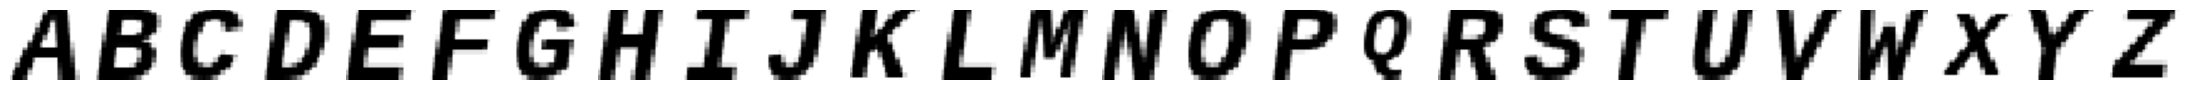

In [4]:

def show_font_tensor( font_tensor: torch.Tensor ) :
  assert font_tensor.shape == (alphabet, image_size, image_size), "font_tensor shape is not valid"

  # plot font image of 26 alphabets
  plt.subplots(1, alphabet, figsize=(image_size, image_size))

  for i in range(alphabet) :
    plt.subplot(1, 26, i+1)
    plt.axis('off')
    plt.imshow(font_tensor[i], cmap='gray')

  plt.show()

def show_font(font_index = np.random.randint(0, font_count)) :
  assert font_count > font_index, "font_index out of range"

  # get font image
  font = data[font_index]

  show_font_tensor(font)

# show random font image
show_font()

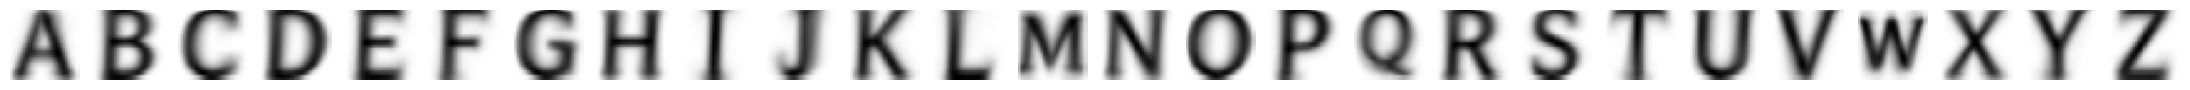

In [5]:
mean = data.mean(axis=0)
show_font_tensor(mean)

In [6]:
# Prepare for 2d convolution
# concat 26 images to 1 image to get height = 28 and width = 28*26
data_2d = data

In [7]:
# show random font image in 2d
random_index = np.random.randint(0, font_count)


In [8]:
class opt :
  n_epochs = 15
  batch_size = 64
  lr = 0.0002
  b1 = 0.5
  b2 = 0.999
  n_cpu = 8
  latent_dim = 100
  img_size = 28
  channels = 1
  sample_interval = 400

In [9]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
opt_channels = 26 
opt_img_size = 28
opt_latent_dim = 100

img_shape = (opt_channels, opt_img_size, opt_img_size)



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt_latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [10]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [11]:
# define dataloader from data_2d 
# Configure data loader
dataloader = torch.utils.data.DataLoader(data_2d, batch_size=opt.batch_size, shuffle=True)

In [19]:
losses = []

for epoch in range(opt.n_epochs):
    for i, (imgs) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(
            Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        losses.append((d_loss.item(), g_loss.item()))

        batches_done = epoch * len(dataloader) + i
    iteration = str(epoch)
    path = 'weights/'

    torch.save(generator.state_dict(), path + iteration+'_generator.pth')
    torch.save(discriminator.state_dict(), path + iteration+'_discriminator.pth')


[Epoch 0/15] [Batch 0/12] [D loss: 1.288153] [G loss: 2.705522]
[Epoch 0/15] [Batch 1/12] [D loss: 0.633999] [G loss: 0.446681]
[Epoch 0/15] [Batch 2/12] [D loss: 0.620833] [G loss: 0.465907]
[Epoch 0/15] [Batch 3/12] [D loss: 0.604268] [G loss: 0.818383]
[Epoch 0/15] [Batch 4/12] [D loss: 0.585441] [G loss: 0.726496]
[Epoch 0/15] [Batch 5/12] [D loss: 0.596979] [G loss: 0.553702]
[Epoch 0/15] [Batch 6/12] [D loss: 0.622822] [G loss: 0.691073]
[Epoch 0/15] [Batch 7/12] [D loss: 0.645933] [G loss: 0.515207]
[Epoch 0/15] [Batch 8/12] [D loss: 0.680105] [G loss: 0.632616]
[Epoch 0/15] [Batch 9/12] [D loss: 0.733588] [G loss: 0.396923]
[Epoch 0/15] [Batch 10/12] [D loss: 0.725520] [G loss: 0.818333]
[Epoch 0/15] [Batch 11/12] [D loss: 0.709776] [G loss: 0.356361]
[Epoch 1/15] [Batch 0/12] [D loss: 0.606748] [G loss: 0.790168]
[Epoch 1/15] [Batch 1/12] [D loss: 0.551122] [G loss: 0.696966]
[Epoch 1/15] [Batch 2/12] [D loss: 0.517534] [G loss: 0.733495]
[Epoch 1/15] [Batch 3/12] [D loss: 0.5

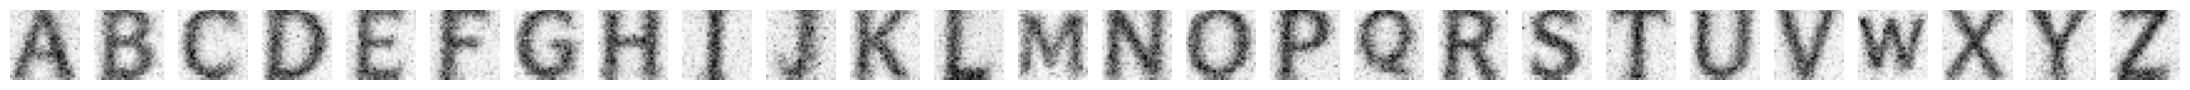

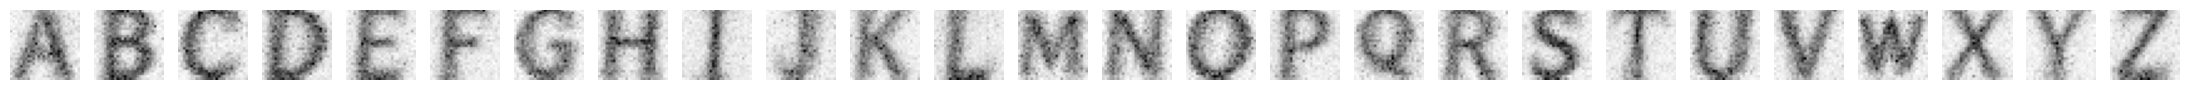

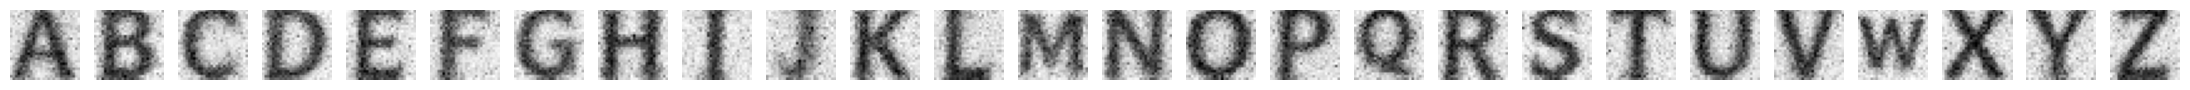

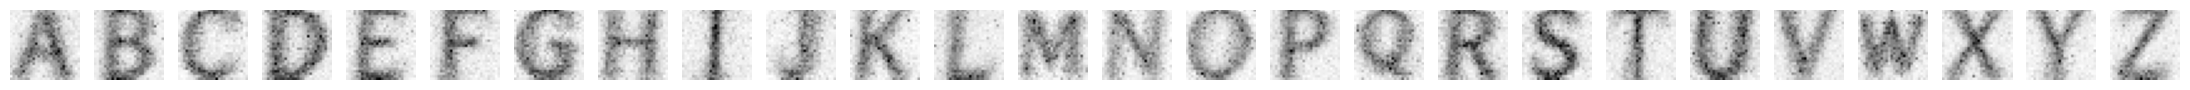

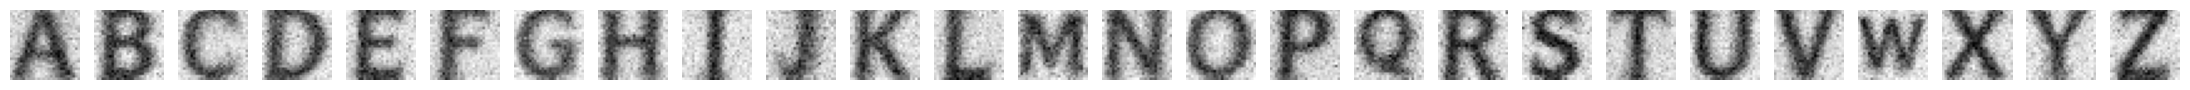

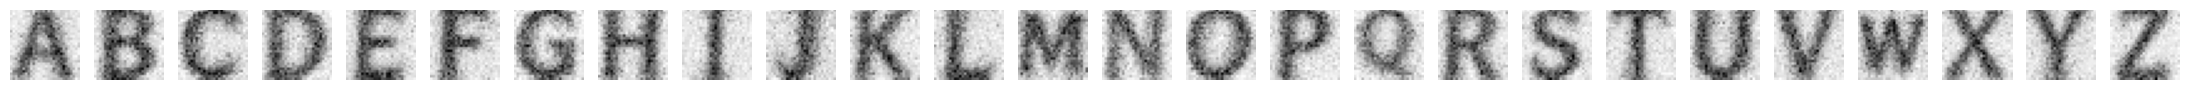

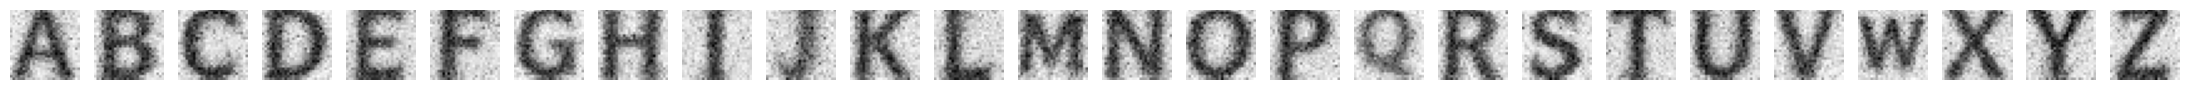

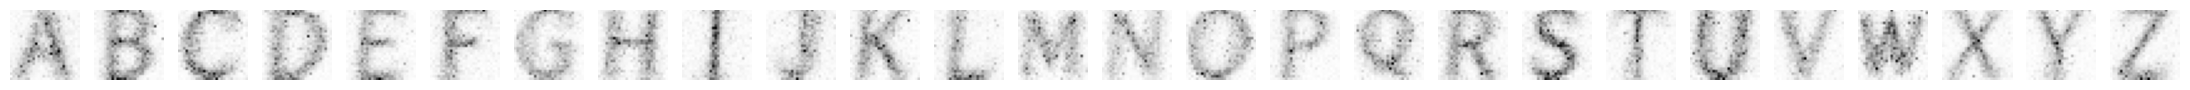

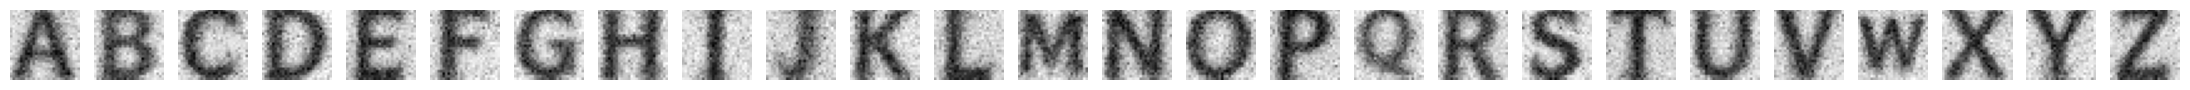

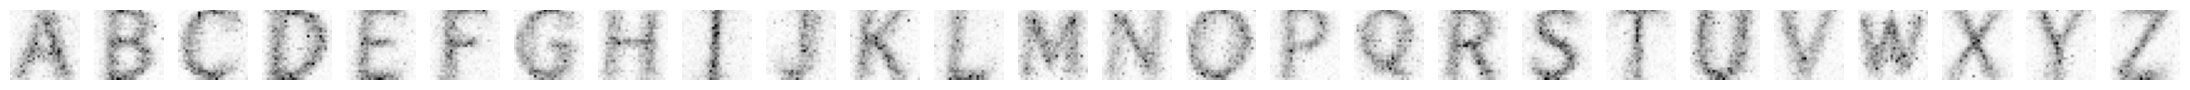

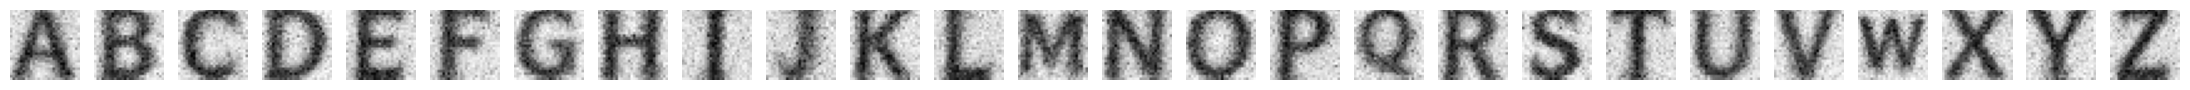

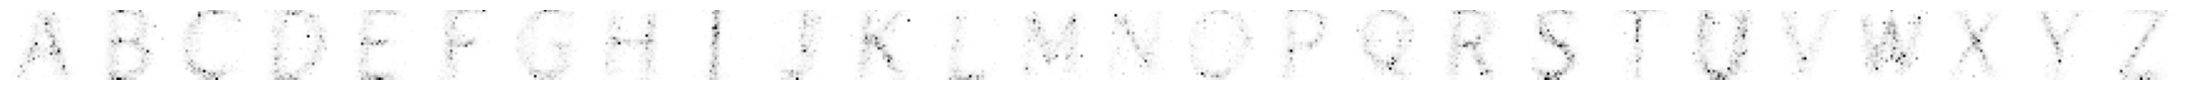

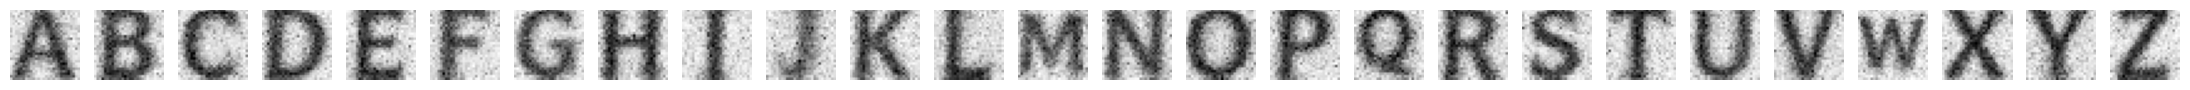

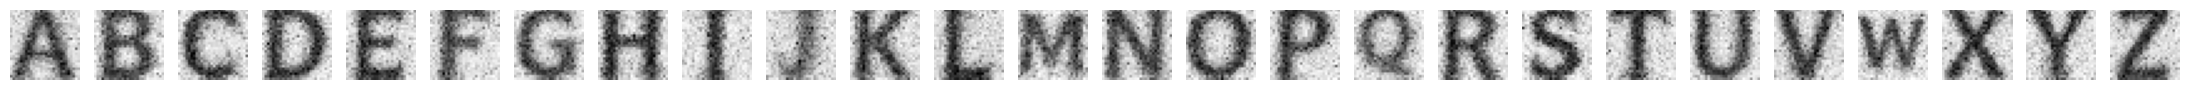

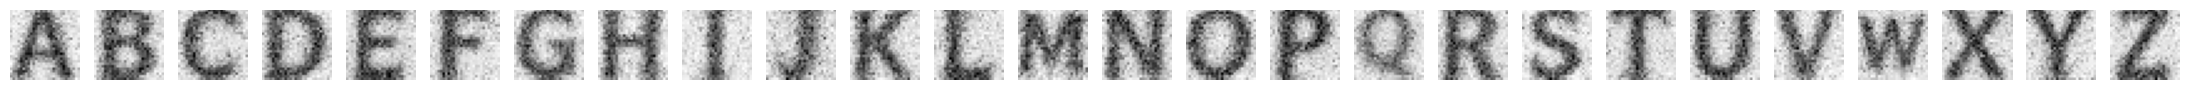

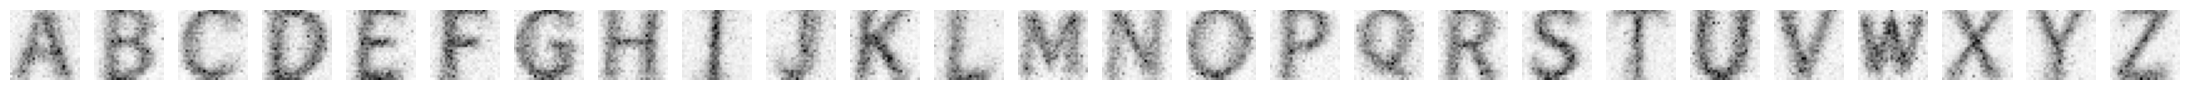

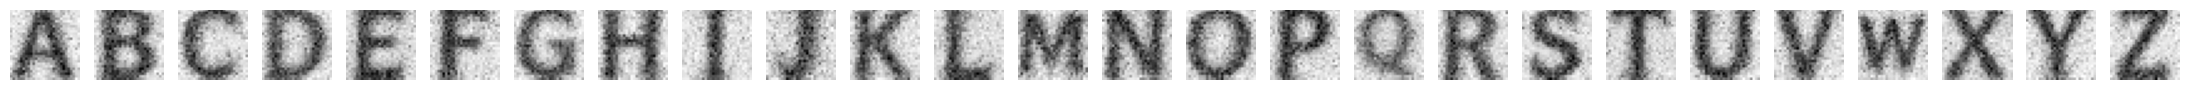

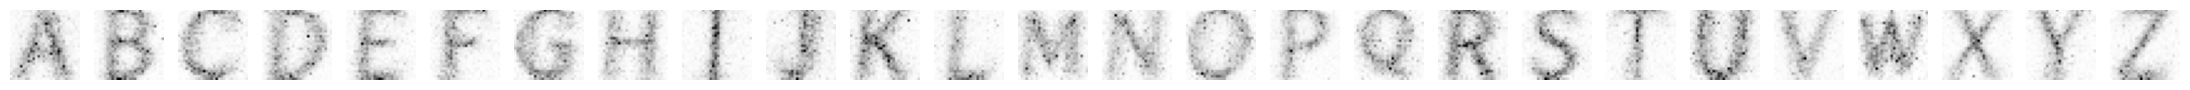

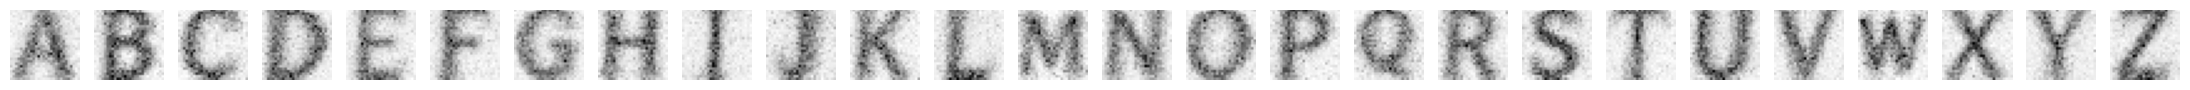

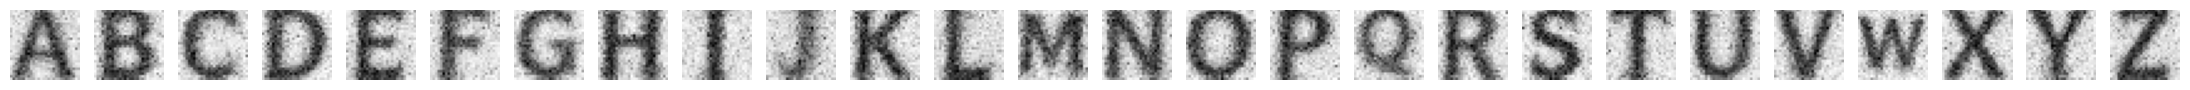

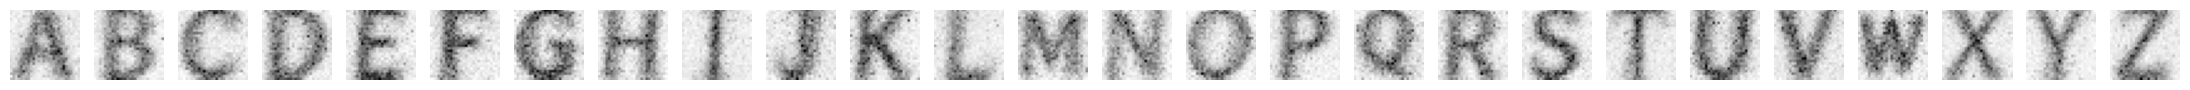

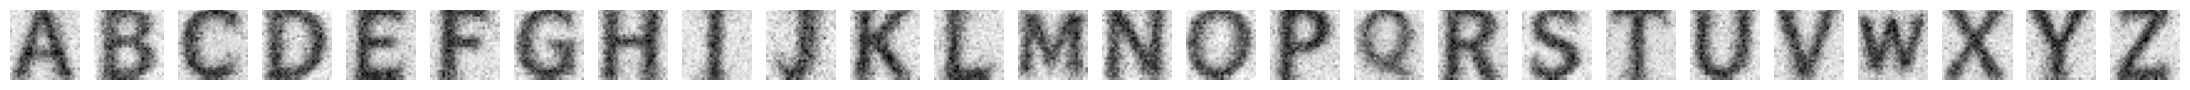

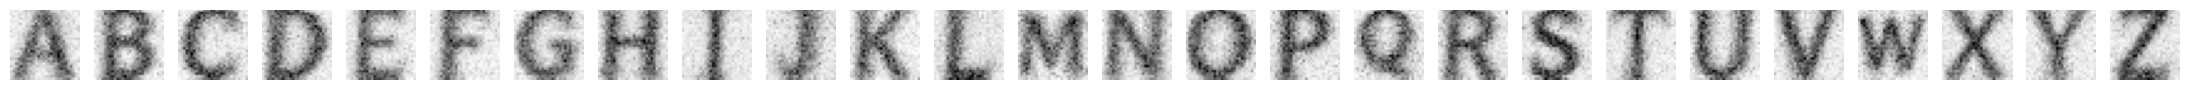

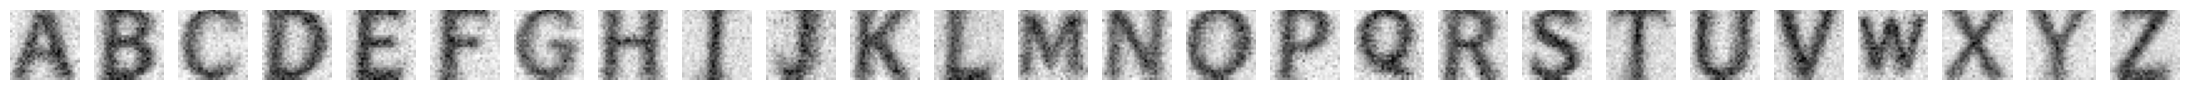

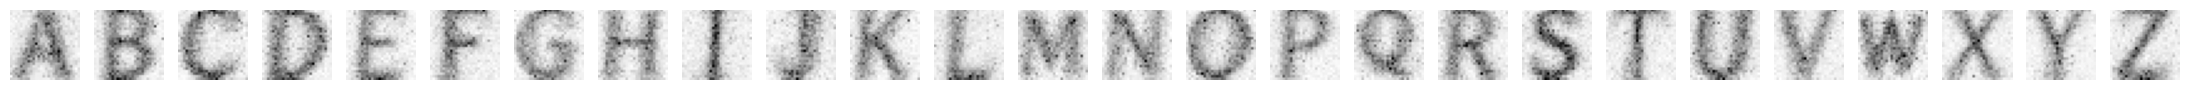

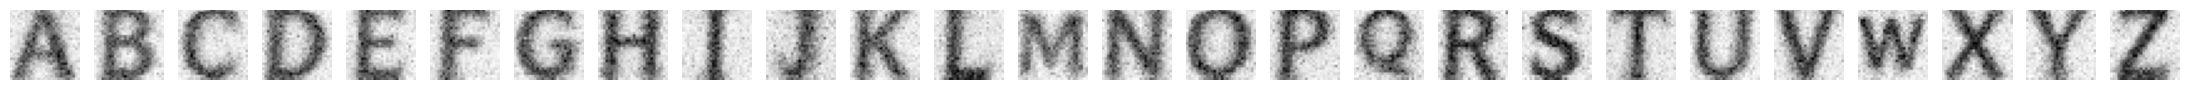

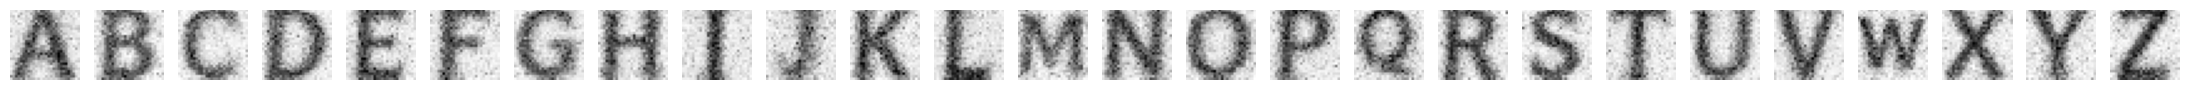

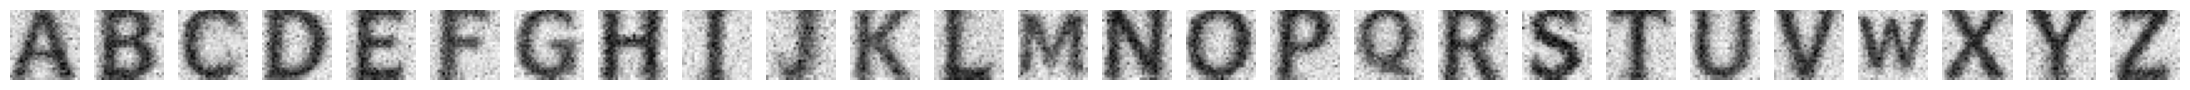

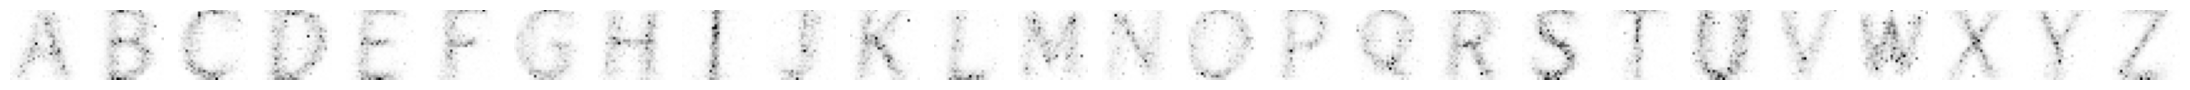

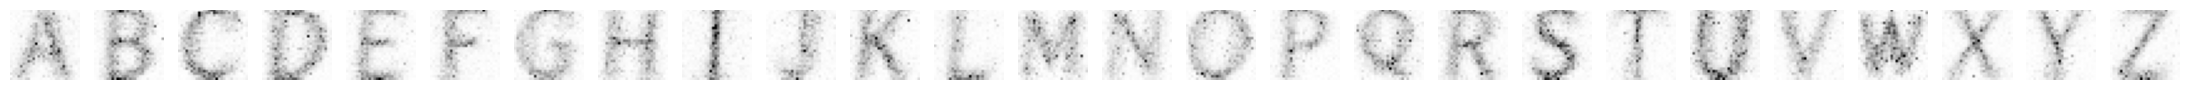

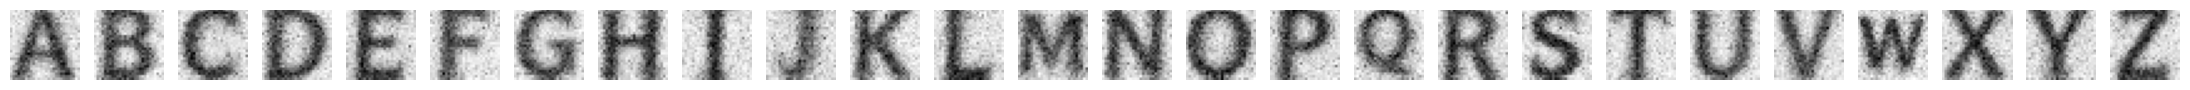

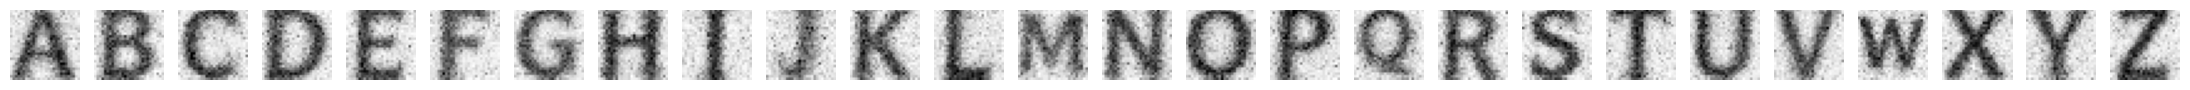

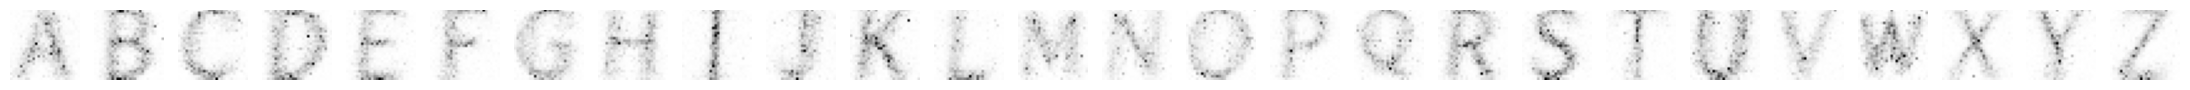

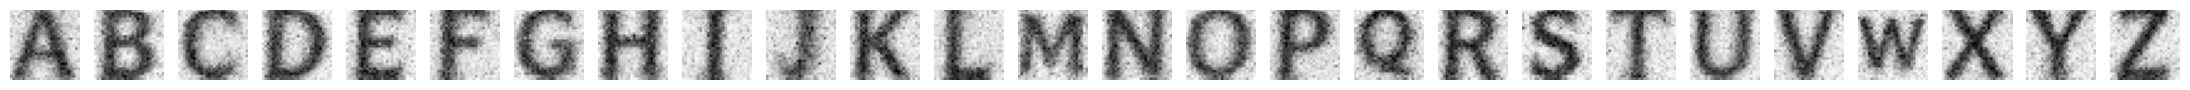

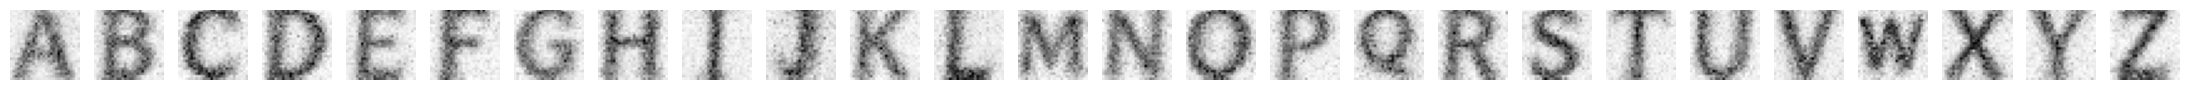

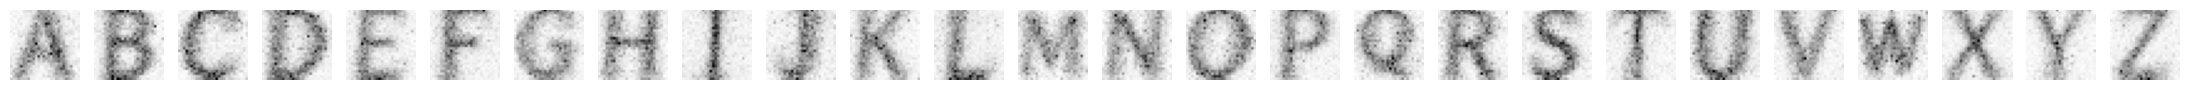

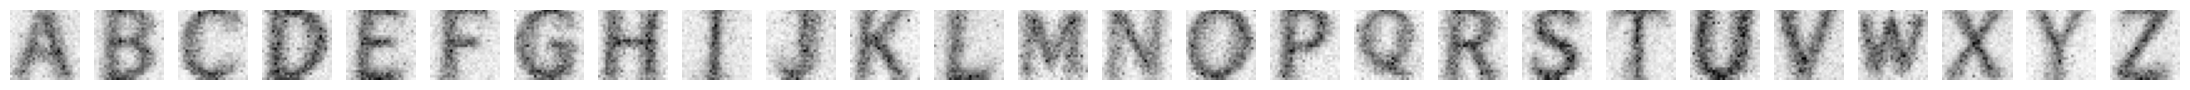

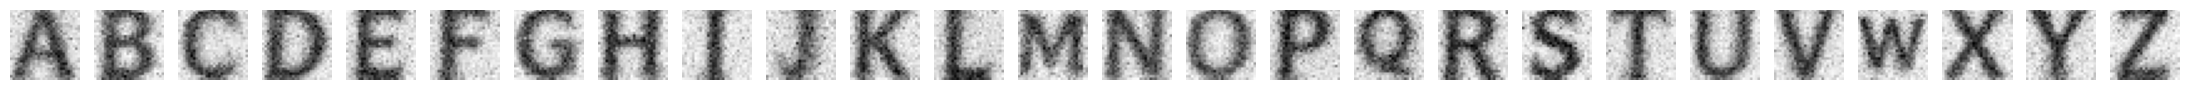

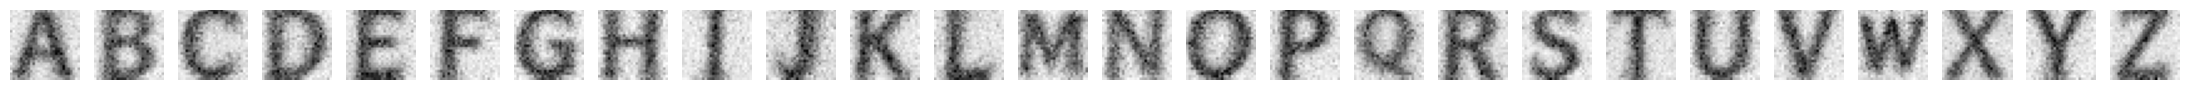

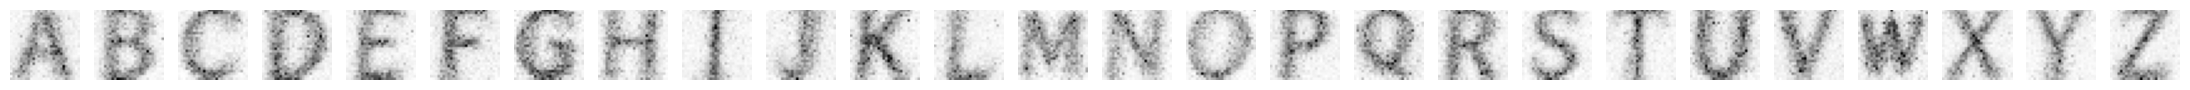

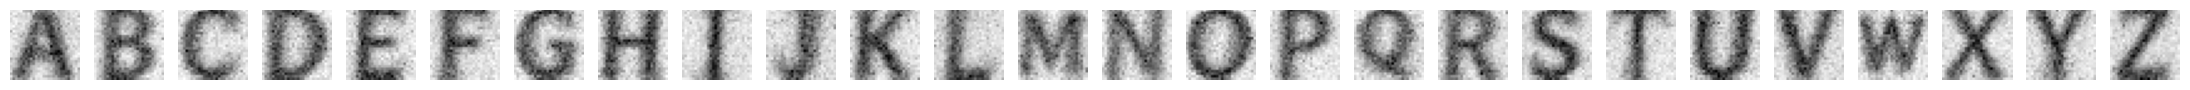

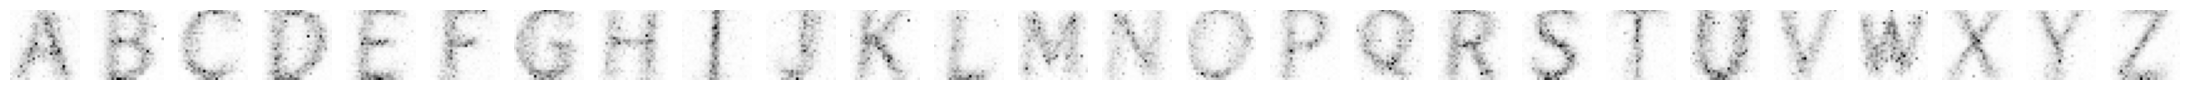

In [20]:
for i in range(len(gen_imgs)) :
  show_font_tensor(gen_imgs[i].detach().cpu().numpy())

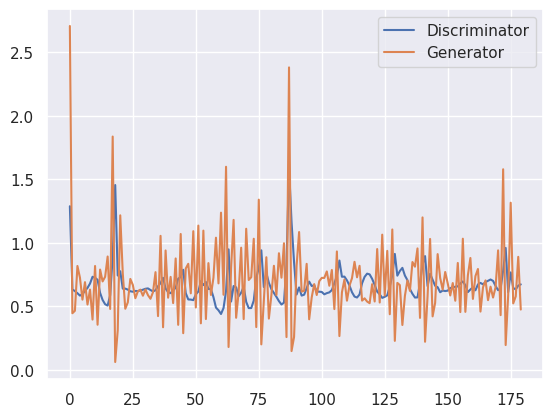

In [22]:
plt.plot(losses)
plt.legend(['Discriminator', 'Generator'])
plt.show()